In [41]:
import pandas as pd
import numpy as np
from scipy import stats 
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
import warnings
warnings.filterwarnings("ignore")

In [42]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
# Load the dataset
train = pd.read_csv('E:\\predect_caloreis\\playground-series-s5e5\\train.csv')
test = pd.read_csv('E:\\predect_caloreis\\playground-series-s5e5\\test.csv')
submission = pd.read_csv('E:\\predect_caloreis\\playground-series-s5e5\\sample_submission.csv')
# Display the first few rows of the training data
train.head(10)




,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
5,5,female,26,156.0,56.0,19.0,100.0,40.5,103.0
6,6,female,21,172.0,73.0,3.0,81.0,38.3,9.0
7,7,male,46,188.0,94.0,23.0,100.0,40.8,145.0
8,8,female,33,166.0,63.0,25.0,107.0,40.5,161.0
9,9,male,65,185.0,88.0,23.0,104.0,41.0,185.0


In [43]:
# Display the first few rows of the test data
test.head(10) 




,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5
5,750005,female,43,169.0,65.0,6.0,81.0,39.4
6,750006,male,74,189.0,97.0,9.0,86.0,40.0
7,750007,male,60,186.0,90.0,2.0,79.0,38.1
8,750008,male,21,196.0,91.0,4.0,84.0,38.7
9,750009,male,32,189.0,89.0,29.0,111.0,40.8


In [44]:
# Display the first few rows of the submission data
submission.head(10)


,id,Calories
0,750000,88.283
1,750001,88.283
2,750002,88.283
3,750003,88.283
4,750004,88.283
5,750005,88.283
6,750006,88.283
7,750007,88.283
8,750008,88.283
9,750009,88.283


EDA

In [45]:
# start EDA
# Check for missing values in the training data
train.isnull().sum()


id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

==== معلومات عامة عن البيانات ====
شكل بيانات التدريب: (750000, 9)
شكل بيانات الاختبار: (250000, 8)

أنواع الأعمدة:
id              int64
Sex            object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object

عدد القيم الفريدة في كل عمود:
id            750000
Sex                2
Age               60
Height            86
Weight            91
Duration          30
Heart_Rate        63
Body_Temp         75
Calories         277
dtype: int64

==== القيم المفقودة ====
تدريب:
 id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64
اختبار:
 id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64

==== إحصائيات وصفية للبيانات العددية ====


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


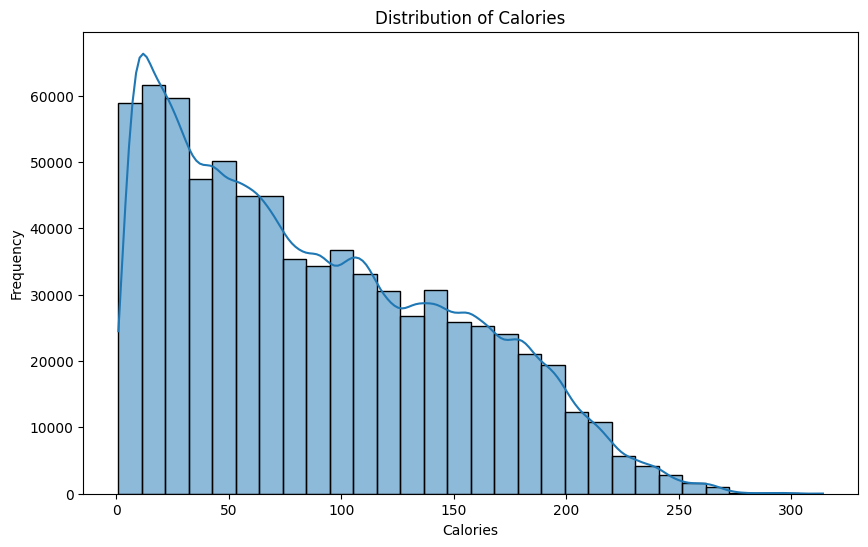

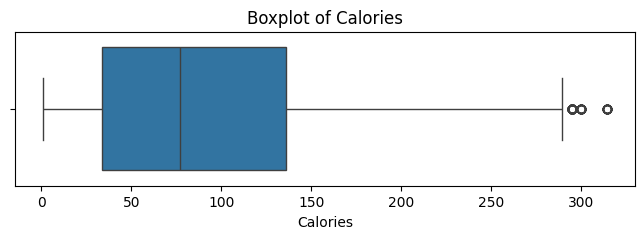

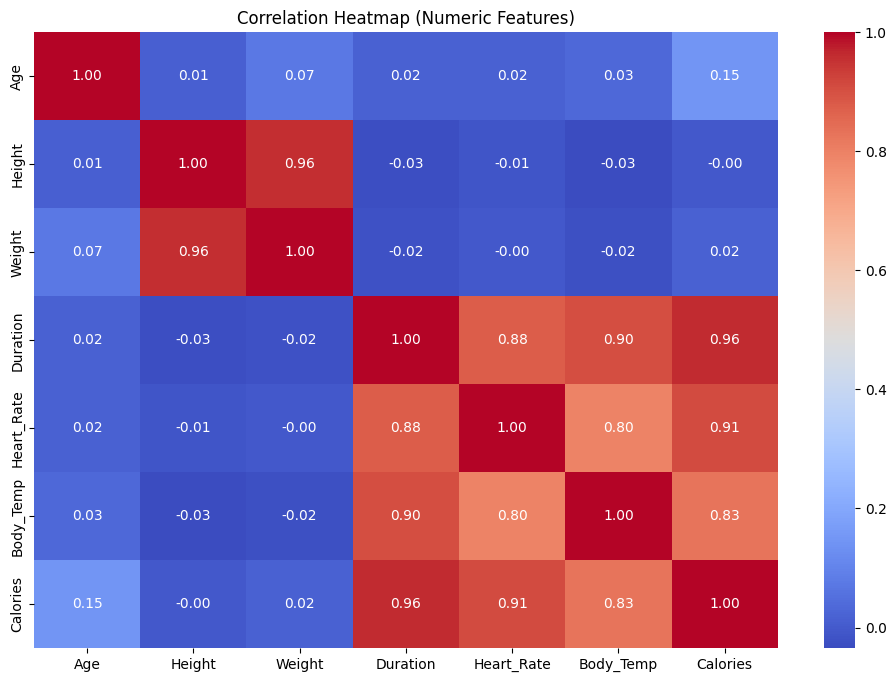

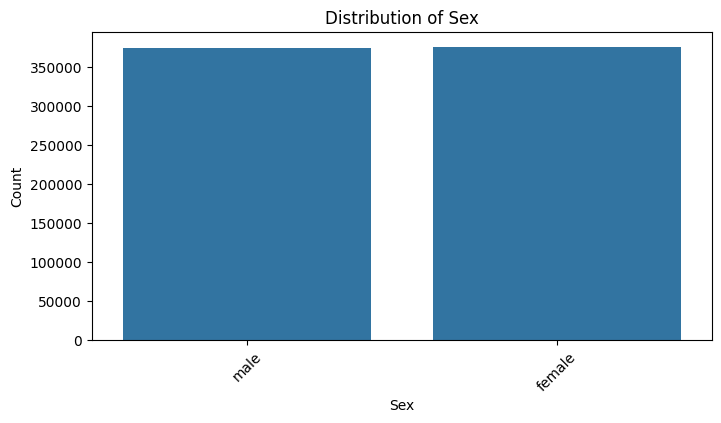

Sex
female    375721
male      374279
Name: count, dtype: int64


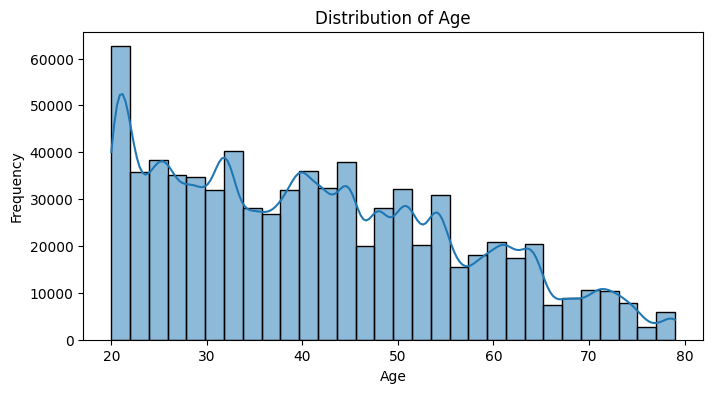

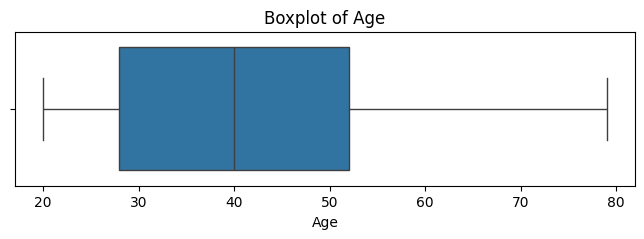

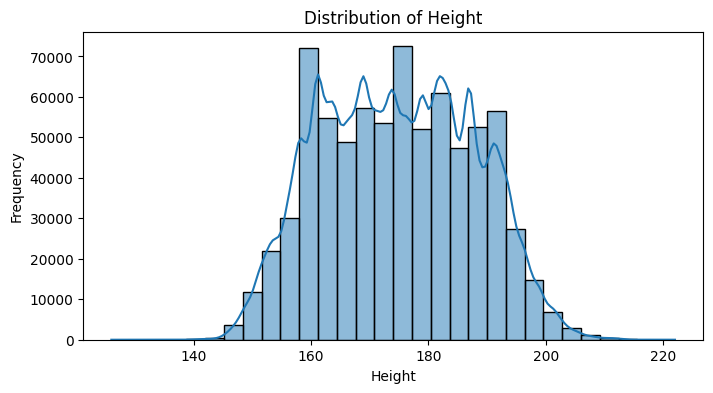

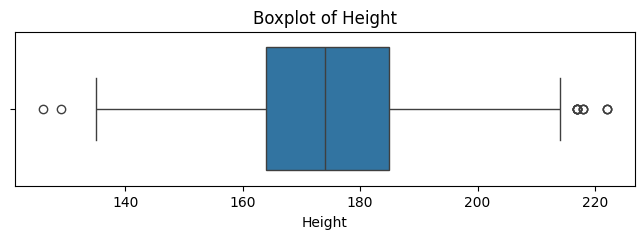

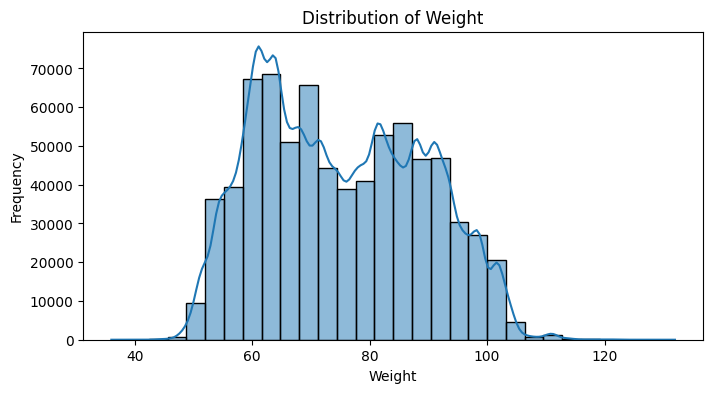

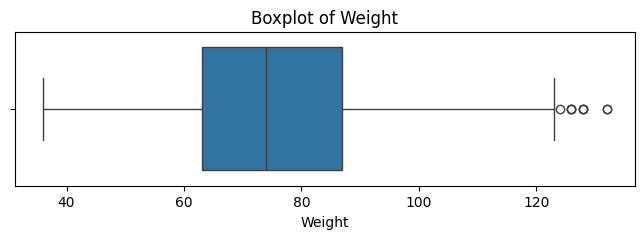

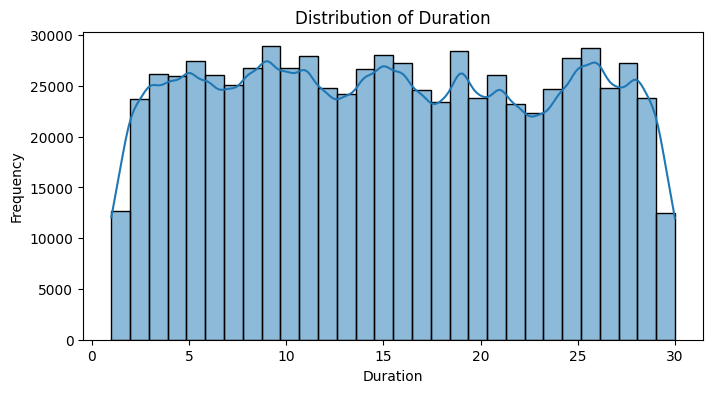

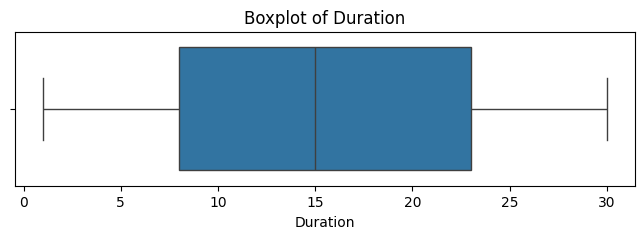

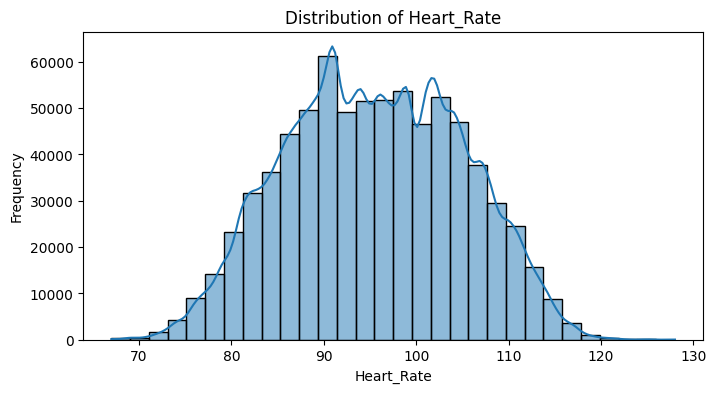

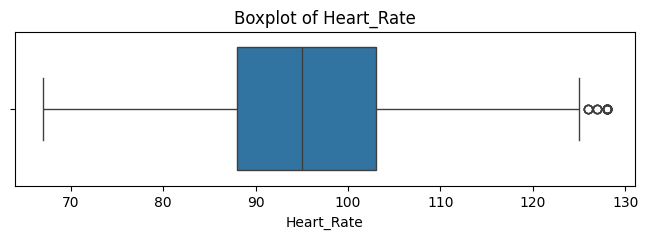

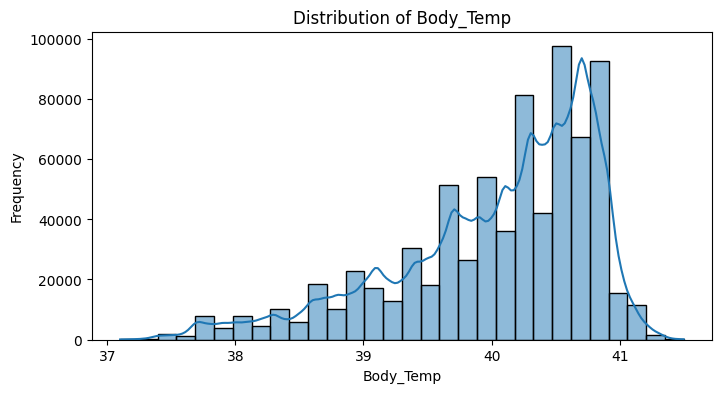

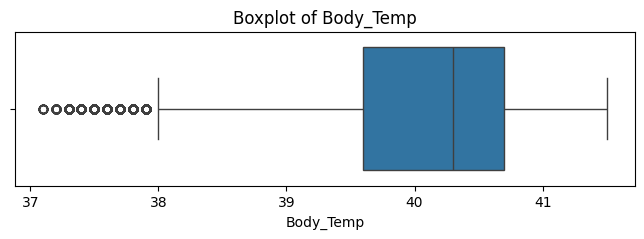

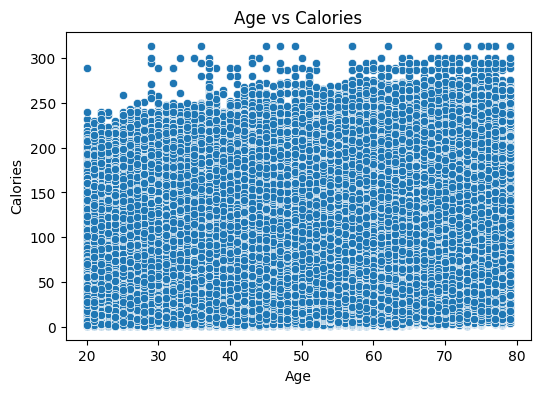

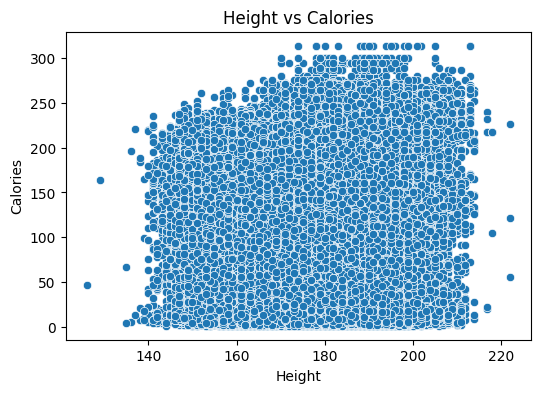

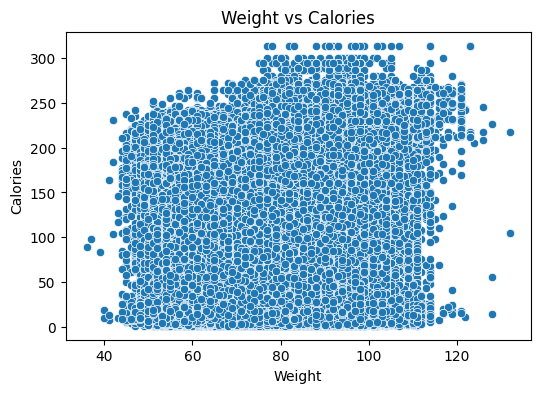

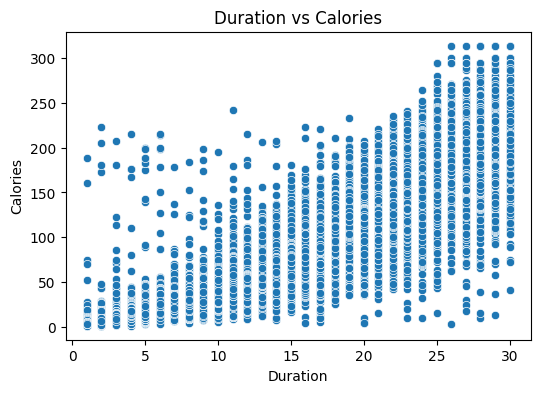

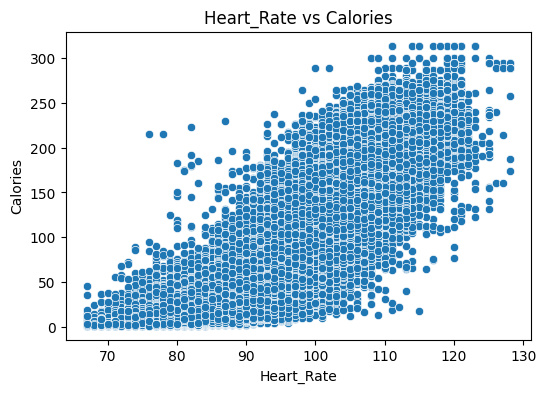

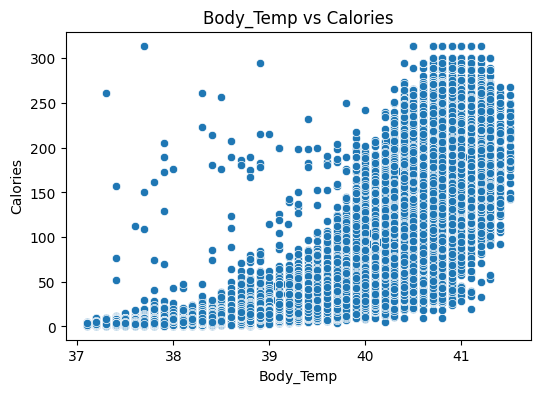

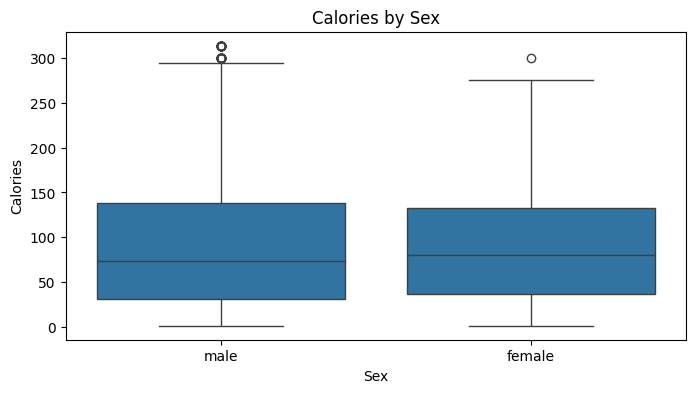


==== القيم الشاذة في المتغيرات العددية ====
Age: عدد القيم الشاذة = 0
Height: عدد القيم الشاذة = 38
Weight: عدد القيم الشاذة = 104
Duration: عدد القيم الشاذة = 0
Heart_Rate: عدد القيم الشاذة = 175
Body_Temp: عدد القيم الشاذة = 3368

==== متوسط السعرات لكل قيمة فئوية ====
Sex
female    87.534761
male      89.033683
Name: Calories, dtype: float64


In [46]:
# EDA احترافي مع معالجة الأعمدة الفئوية

print("==== معلومات عامة عن البيانات ====")
print("شكل بيانات التدريب:", train.shape)
print("شكل بيانات الاختبار:", test.shape)
print("\nأنواع الأعمدة:")
print(train.dtypes)
print("\nعدد القيم الفريدة في كل عمود:")
print(train.nunique())

print("\n==== القيم المفقودة ====")
print("تدريب:\n", train.isnull().sum())
print("اختبار:\n", test.isnull().sum())

print("\n==== إحصائيات وصفية للبيانات العددية ====")
display(train.describe())

# حذف عمود id إذا كان موجود
if 'id' in train.columns:
    train = train.drop('id', axis=1)

# التأكد من اسم العمود المستهدف
target_col = 'calories' if 'calories' in train.columns else 'Calories'

# توزيع المتغير المستهدف
plt.figure(figsize=(10, 6))
sns.histplot(train[target_col], bins=30, kde=True)
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

# Boxplot للمتغير المستهدف
plt.figure(figsize=(8, 2))
sns.boxplot(x=train[target_col])
plt.title('Boxplot of Calories')
plt.show()

# مصفوفة الارتباط (فقط للأعمدة الرقمية)
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

# توزيع المتغيرات الفئوية
categorical_features = train.select_dtypes(include=['object']).columns
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=train, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    print(train[feature].value_counts())

# توزيع المتغيرات العددية
numerical_features = [col for col in numeric_cols if col != target_col]
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=train[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

# العلاقة بين المتغيرات العددية والمتغير المستهدف
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=train[feature], y=train[target_col])
    plt.title(f'{feature} vs Calories')
    plt.xlabel(feature)
    plt.ylabel('Calories')
    plt.show()

# العلاقة بين المتغيرات الفئوية والمتغير المستهدف
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train[feature], y=train[target_col])
    plt.title(f'Calories by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Calories')
    plt.show()

# تحليل القيم الشاذة للمتغيرات العددية
print("\n==== القيم الشاذة في المتغيرات العددية ====")
from scipy import stats
for feature in numerical_features:
    z_scores = np.abs(stats.zscore(train[feature]))
    outliers = (z_scores > 3).sum()
    print(f"{feature}: عدد القيم الشاذة = {outliers}")

# تحليل الارتباط بين المتغيرات الفئوية والمتغير المستهدف باستخدام المتوسط
print("\n==== متوسط السعرات لكل قيمة فئوية ====")
for feature in categorical_features:
    print(train.groupby(feature)[target_col].mean())

In [47]:
# معالجة القيم الشاذة (outliers) في المتغيرات العددية

from scipy import stats

# تحديد الأعمدة العددية (عدا المتغير المستهدف)
target_col = 'calories' if 'calories' in train.columns else 'Calories'
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
numerical_features = [col for col in numeric_cols if col != target_col]

# حساب z-score لكل عمود عددي
z_scores = np.abs(stats.zscore(train[numerical_features]))

# تحديد الصفوف التي تحتوي على أي outlier (z-score > 3)
outlier_rows = (z_scores > 3).any(axis=1)
print(f"عدد الصفوف قبل الحذف: {train.shape[0]}")
print(f"عدد الصفوف التي تحتوي على outliers: {outlier_rows.sum()}")

# حذف الصفوف التي تحتوي على outliers
train = train[~outlier_rows].reset_index(drop=True)
print(f"عدد الصفوف بعد الحذف: {train.shape[0]}")

عدد الصفوف قبل الحذف: 750000
عدد الصفوف التي تحتوي على outliers: 3661
عدد الصفوف بعد الحذف: 746339


In [49]:
# 1. حمل البيانات
train = pd.read_csv('E:\\predect_caloreis\\playground-series-s5e5\\train.csv')
test = pd.read_csv('E:\\predect_caloreis\\playground-series-s5e5\\test.csv')
submission = pd.read_csv('E:\\predect_caloreis\\playground-series-s5e5\\sample_submission.csv')

# 2. حذف outliers
from scipy import stats
target_col = 'calories' if 'calories' in train.columns else 'Calories'
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
numerical_features = [col for col in numeric_cols if col != target_col]
z_scores = np.abs(stats.zscore(train[numerical_features]))
outlier_rows = (z_scores > 3).any(axis=1)
train = train[~outlier_rows].reset_index(drop=True)

# 3. تجهيز البيانات
if 'id' in train.columns:
    train = train.drop('id', axis=1)
if 'id' in test.columns:
    test = test.drop('id', axis=1)
categorical_features = train.select_dtypes(include=['object']).columns
from sklearn.preprocessing import LabelEncoder
for col in categorical_features:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

# 4. فصل الميزات والهدف
X = train.drop(target_col, axis=1)
y = train[target_col]

# 5. تقسيم البيانات
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. بناء الموديل
import lightgbm as lgb
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}
model = lgb.LGBMRegressor(**params, n_estimators=1000)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)

# تقييم الموديل
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# التنبؤ على بيانات الاختبار
test_pred = model.predict(test)
submission_col = submission.columns[-1]
submission[submission_col] = test_pred
submission.to_csv('E:\\predect_caloreis\\playground-series-s5e5\\sample_submission.csv', index=False)
print("تم حفظ ملف submission_lgbm.csv بنجاح!")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 597071, number of used features: 7
[LightGBM] [Wa